In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/content/Churn_Modelling.csv')
print("Shape:", df.shape)
df.head()

Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Text(0.5, 1.0, 'Churn Distribution')

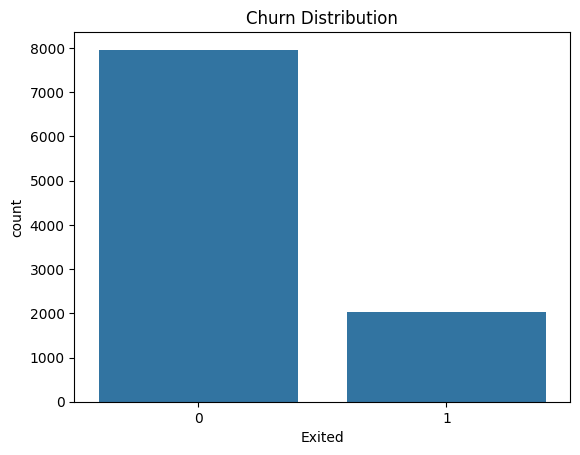

In [ ]:
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')

Text(0.5, 1.0, 'Feature Correlation Heatmap')

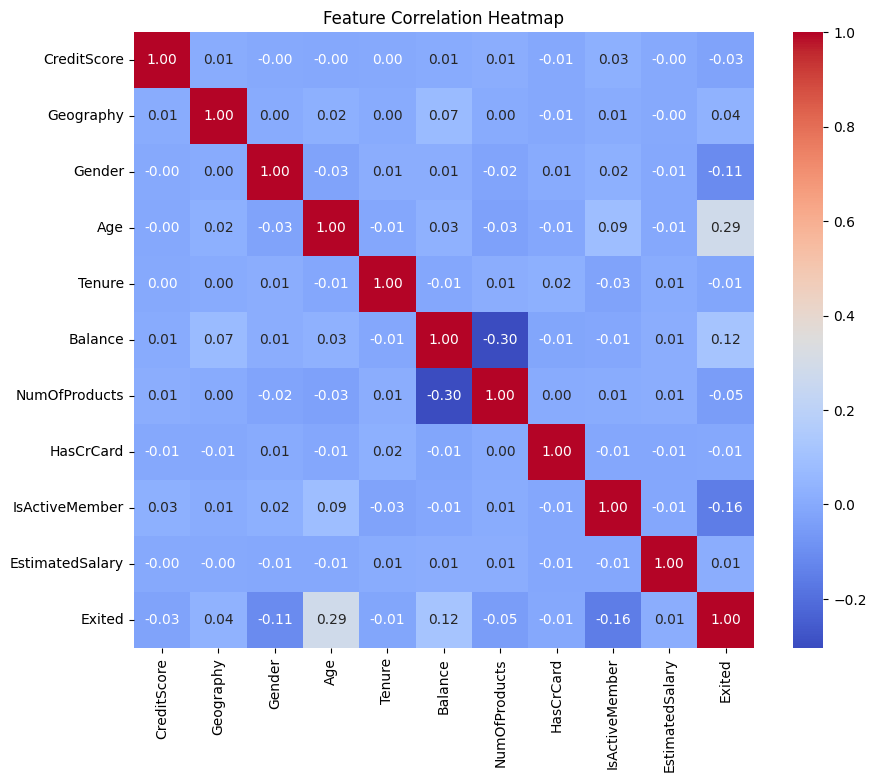

In [ ]:

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')


In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Geography'] = le.fit_transform(df['Geography'])

df['Exited'] = df['Exited'].astype(int)

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [5]:
X = df.drop('Exited', axis=1)
y = df['Exited']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [8]:
def evaluate(model_name, y_true, y_pred):
    print(f"------ {model_name} ------")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print()

evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("XGBoost", y_test, y_pred_xgb)


------ Logistic Regression ------
Accuracy: 0.805
ROC AUC: 0.558384270248677
Confusion Matrix:
 [[1552   41]
 [ 349   58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.14      0.23       407

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.81      0.75      2000


------ Random Forest ------
Accuracy: 0.864
ROC AUC: 0.7106644394779988
Confusion Matrix:
 [[1544   49]
 [ 223  184]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000


------ XGBoost ------
Accuracy: 0.847
ROC AUC: 0.703651

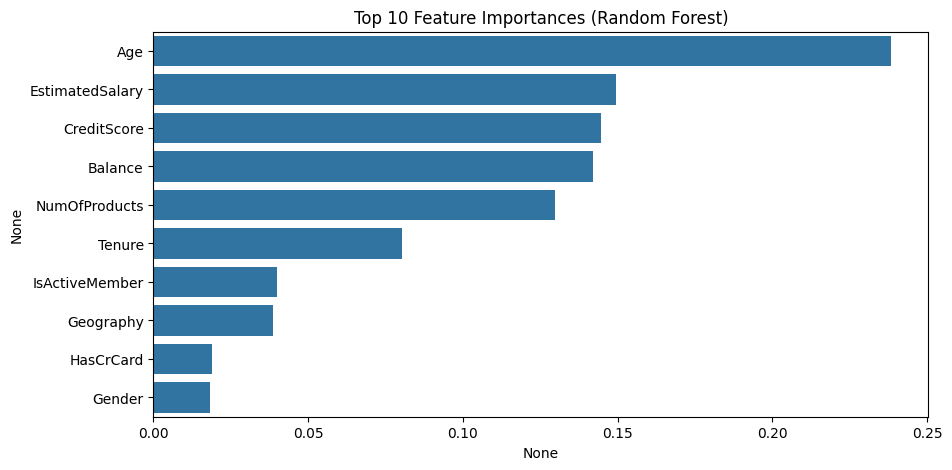

In [9]:
feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance[:10], y=feat_importance.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [13]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred_lr),
                 accuracy_score(y_test, y_pred_rf),
                 accuracy_score(y_test, y_pred_xgb)],
    "ROC AUC": [roc_auc_score(y_test, y_pred_lr),
                roc_auc_score(y_test, y_pred_rf),
                roc_auc_score(y_test, y_pred_xgb)]
})
print(results)


                 Model  Accuracy   ROC AUC
0  Logistic Regression     0.805  0.558384
1        Random Forest     0.864  0.710664
2              XGBoost     0.847  0.703651


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)


Best Params: {'max_depth': 8, 'n_estimators': 200}


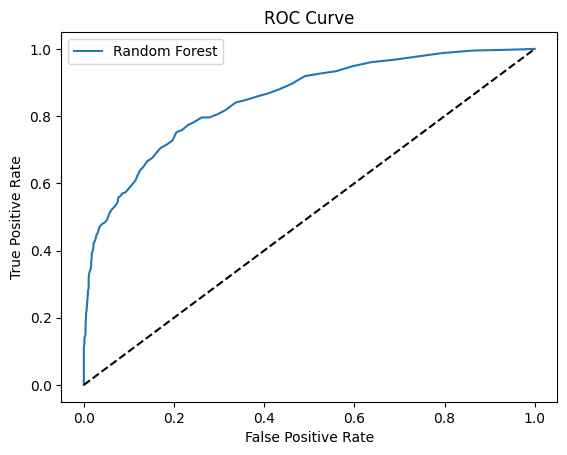

In [16]:
from sklearn.metrics import roc_curve

y_probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
